# 합성곱 신경망 구현
- 참고: 밑바닥부터 시작하는 딥러닝1

### 합성곱 층 (Convolution Layer)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import requests
from io import BytesIO

In [2]:
def url_to_image(url, gray = False):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype = 'uint8')
    
    if gray == True:
        image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    return image

In [35]:
def im2col(input_data, filter_h, filter_w, stride = 1, pad = 0):
    N, C, H, W = input_data.shape
    
    out_h = (H +2*pad - filter_h) // stride + 1
    out_w = (W +2*pad - filter_w) // stride + 1
    
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C,filter_h ,filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride = 1 , pad = 0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)
    
    img = np.zeros((N, C, H + 2*pad + stride -1, W + 2 * pad + stride - 1))
    
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
            
    return img[:, :, pad:H+pad, pad:W+pad]

In [4]:
class Conv2D:
    def __init__(self,W,b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.input_data = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db= None
        
    def forward(self, input_data):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = input_data.shape
        
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W + 2 * self.pad - FW) // self.stride + 1
        
        col = im2col(input_data,FH,FW,self.stride,self.pad)
        col_W = self.W.reshape(FN,-1).T
        
        out = np.dot(col, col_W)+ self.b
        output = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.input_data = input_data
        self.col = col
        self.col_W = col_W
        
        return output
    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis= 0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.input_data.shape,FH,FW,self.stride, self.pad)
        
        return dx

### 컨볼루션 레이어 테스트

In [5]:
def init_weight(num_filters, data_dim, kernel_size, stride = 1, pad = 0, weight_std = 0.01):
    weights = weight_std * np.random.randn(num_filters, data_dim, kernel_size, kernel_size)
    biases = np.zeros(num_filters)
    
    return weights, biases


image_gray.shape :  (440, 440, 1)


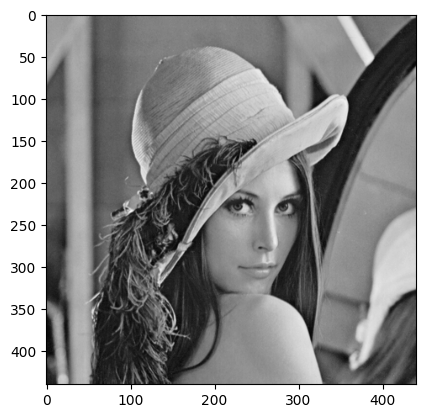

In [6]:
img_url = "https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/440px-Lenna.png"
image_gray = url_to_image(img_url, gray=True)
image_gray = image_gray.reshape(image_gray.shape[0],-1,1)
print("image_gray.shape : ", image_gray.shape)

image_gray = np.expand_dims(image_gray.transpose(2, 0, 1), axis = 0)


plt.imshow(image_gray[0, 0, :, :], cmap='gray')
plt.show()

In [7]:
W, b = init_weight(1,1,3)
conv = Conv2D(W,b)
output = conv.forward(image_gray)

print("Conv Layer size", output.shape)


Conv Layer size (1, 1, 438, 438)


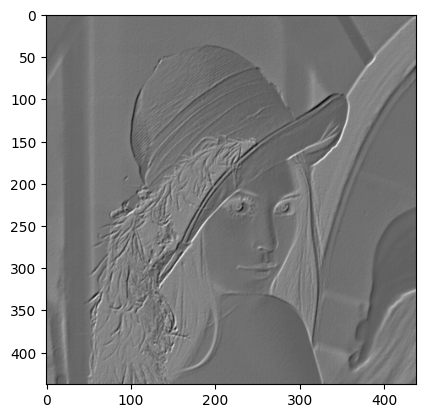

In [8]:
plt. imshow(output[0,0,:,:], cmap='gray')

In [9]:
W2, b2 = init_weight(1,1,3,stride=2)
conv2 = Conv2D(W2,b2,stride=2)
output2 = conv2.forward(image_gray)

print("Conv Layer size", output2.shape)

Conv Layer size (1, 1, 219, 219)


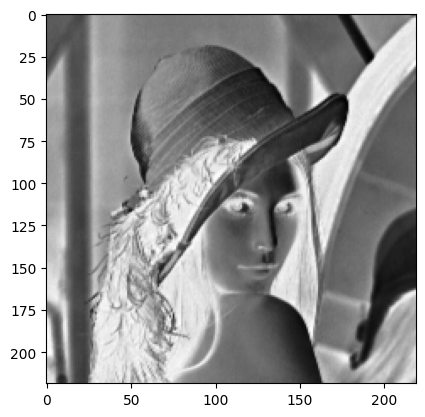

In [10]:
plt.imshow(output2[0,0,:,:], cmap='gray')
plt.show()


image_color.shape :  (440, 440, 3)


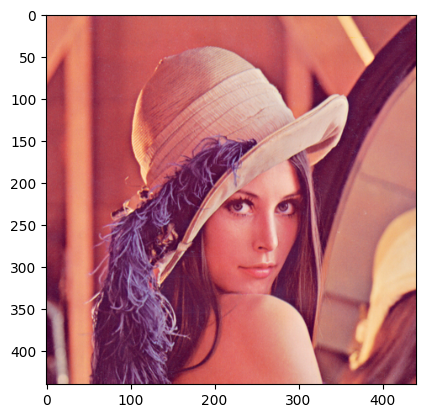

image_color.shape :  (1, 3, 440, 440)


In [11]:
img_url = "https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/440px-Lenna.png"
image_color = url_to_image(img_url)
print("image_color.shape : ", image_color.shape)

plt.imshow(image_color)
plt.show()

image_color = np.expand_dims(image_color.transpose(2, 0, 1), axis = 0)
print("image_color.shape : ", image_color.shape)

In [12]:
W3, b3 = init_weight(10, 3, 3)
conv3 = Conv2D(W3,b3)
output3 = conv3.forward(image_color)

print("Conv Layer size", output3.shape)

Conv Layer size (1, 10, 438, 438)


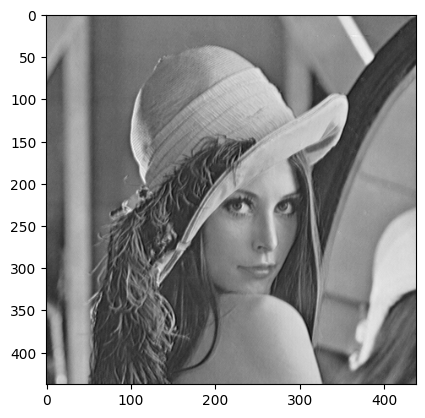

In [30]:
plt.imshow(output3[0, 3,:,:],cmap='gray')
plt.show()

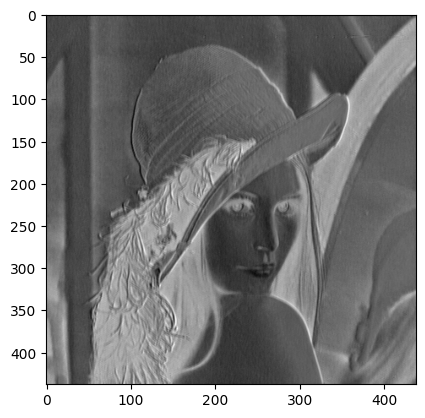

In [14]:
plt.imshow(output3[0,9,:,:],cmap='gray')
plt.show()

### 동일한 이미지 여러 장 테스트 (배치 처리)

In [15]:
img_url = "https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/440px-Lenna.png"
image_gray = url_to_image(img_url, gray=True)
image_gray = image_gray.reshape(image_gray.shape[0],-1,1)
print("image_gray.shape : ", image_gray.shape)

image_gray = image_gray.transpose(2, 0, 1)
print("image_gray.shape : ", image_gray.shape)

image_gray.shape :  (440, 440, 1)
image_gray.shape :  (1, 440, 440)


In [16]:
batch_image_gray = np.repeat(image_gray[np.newaxis,:,:,:], 15, axis=0)
print(batch_image_gray.shape)

(15, 1, 440, 440)


In [17]:
W4, b4 = init_weight(10, 1, 3, stride=2)
conv4 = Conv2D(W4,b4,stride=2)
output4 = conv4.forward(batch_image_gray)

print("Conv Layer size", output4.shape)

Conv Layer size (15, 10, 219, 219)


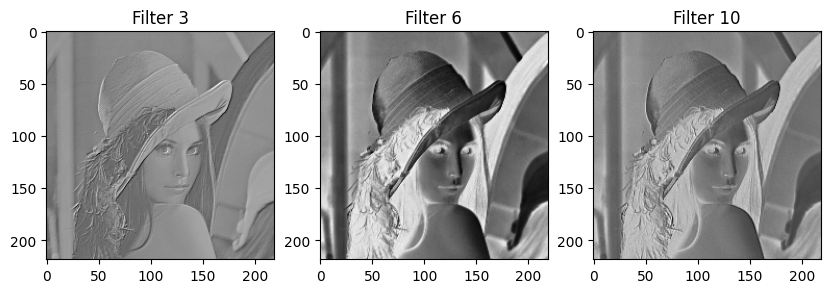

In [32]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Filter 3")
plt.imshow(output4[3,2,:,:], cmap='gray')

plt.subplot(1,3,2)
plt.title("Filter 6")
plt.imshow(output4[3,5,:,:], cmap='gray')

plt.subplot(1,3,3)
plt.title("Filter 10")
plt.imshow(output4[3,9,:,:], cmap='gray')

plt.show()

In [19]:
W5, b5 = init_weight(32, 3, 3, stride=3)
conv5 = Conv2D(W5,b5,stride=3)
output5 = conv5.forward(image_color)

print("Conv Layer size", output5.shape)

Conv Layer size (1, 32, 146, 146)


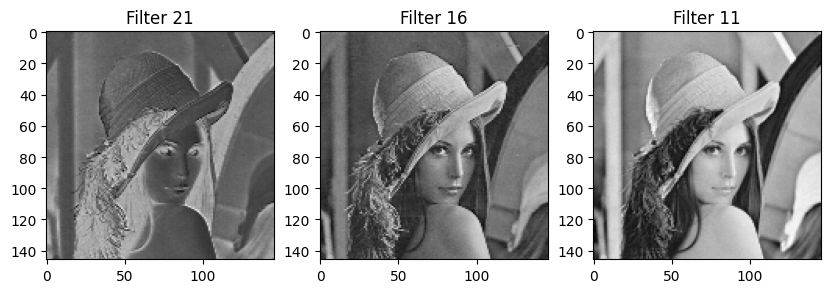

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Filter 21")
plt.imshow(output5[0,20,:,:], cmap='gray')

plt.subplot(1,3,2)
plt.title("Filter 16")
plt.imshow(output5[0,15,:,:], cmap='gray')

plt.subplot(1,3,3)
plt.title("Filter 11")
plt.imshow(output5[0,10,:,:], cmap='gray')

plt.show()

### 동일한 이미지 배치처리(color)

In [24]:
img_url = "https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/440px-Lenna.png"
image_color = url_to_image(img_url)
print("image_color.shape : ", image_color.shape)

image_color = image_color.transpose(2, 0, 1)
print("image_color.shape : ", image_color.shape)

image_color.shape :  (440, 440, 3)
image_color.shape :  (3, 440, 440)


In [25]:
batch_image_color = np.repeat(image_color[np.newaxis,:,:,:], 15, axis=0)
print(batch_image_color.shape)

(15, 3, 440, 440)


In [26]:
W6, b6 = init_weight(64, 3, 5)
conv6 = Conv2D(W6,b6)
output6 = conv6.forward(batch_image_color)

print("Conv Layer size", output6.shape)

Conv Layer size (15, 64, 436, 436)


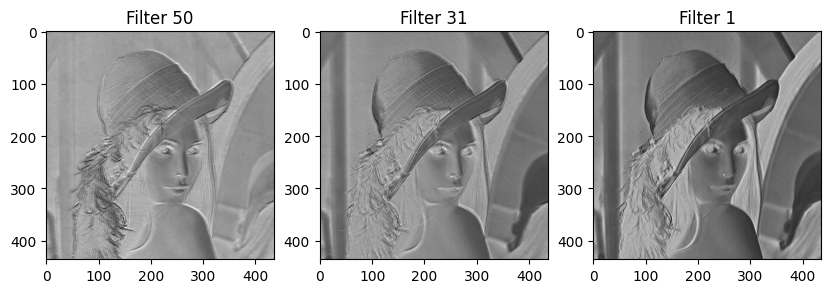

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Filter 50")
plt.imshow(output6[10,49,:,:], cmap='gray')

plt.subplot(1,3,2)
plt.title("Filter 31")
plt.imshow(output6[10,30,:,:], cmap='gray')

plt.subplot(1,3,3)
plt.title("Filter 1")
plt.imshow(output6[10,0,:,:], cmap='gray')

plt.show()

### 풀링 층(Pooling Layer)

In [36]:
class Pooling2D:
    def __init__(self, kernel_size=2, stride=1, pad =0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        
        self.input_data = None
        self.arg_max = None
        
    def forward(self, input_data):
        N, C, H, W =input_data.shape
        out_h = (H - self.kernel_size) // self.stride + 1
        out_w = (W - self.kernel_size) // self.stride + 1
        
        col = im2col(input_data, self.kernel_size, self.kernel_size, self.stride, self.pad)
        col = col.reshape(-1, self.kernel_size * self.kernel_size)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        output = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        
        self.input_data = input_data
        self.arg_max = arg_max
        
        return output
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.kernel_size * self.kernel_size
        dmax = np.zeros((dout.size,pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] =dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.input_data.shape, self.kernel_size, self.kernel_size, self.stride, self.pad)
        
        return dx
    

### 풀링 레이어 테스트
- 2차원 이미디
    - (Height, Width,1)

image.shape :  (440, 440, 1)


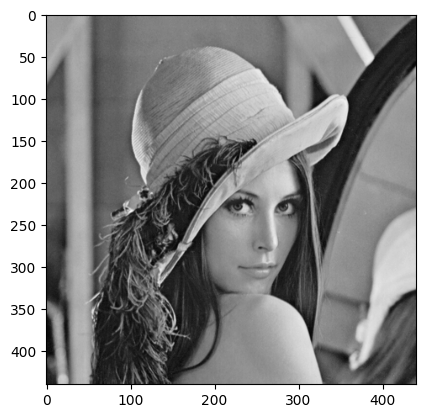

In [39]:
img_url = "https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/440px-Lenna.png"
image_gray = url_to_image(img_url,gray=True)
image_gray = image_gray.reshape(image_gray.shape[0], -1, 1)
print("image.shape : ", image_gray.shape)

image_gray = np.expand_dims(image_gray.transpose(2, 0, 1),axis=0)

plt.imshow(image_gray[0, 0, :, :], cmap='gray')
plt.show()

In [40]:
W, b = init_weight(8, 1, 3)
conv = Conv2D(W, b)
pool = Pooling2D(stride=2, kernel_size=2)

In [41]:
output1 = conv.forward(image_gray)
print("Conv size:", output1.shape)

Conv size: (1, 8, 438, 438)


In [42]:
output1 = pool.forward(output1)
print("Pooling Layer size:", output1.shape)

Pooling Layer size: (1, 8, 219, 219)


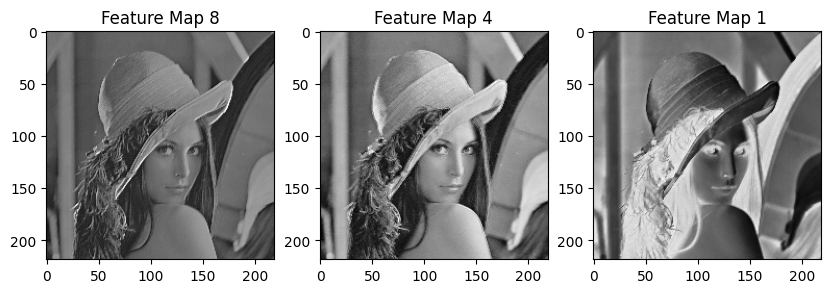

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Feature Map 8")
plt.imshow(output1[0,7,:,:], cmap='gray')

plt.subplot(1,3,2)
plt.title("Feature Map 4")
plt.imshow(output1[0,3,:,:], cmap='gray')

plt.subplot(1,3,3)
plt.title("Feature Map 1")
plt.imshow(output1[0,0,:,:], cmap='gray')

plt.show()